In [1]:
import os
from pathlib import Path
cwd = os.getcwd()
newcwd = Path(cwd).parent.absolute()
os.chdir(newcwd)

In [2]:
import numpy as np
from estructura import Nonograma, FilaColumna, Contenido
from algoritmos.utilidades_ia import cargar_modelo_manual, predecir_usando_ia, convertir_row_of_dataset_into_nonograma, aplicar_transformaciones_correspondientes
from deeplearning_utils.utilidades import load_data
from tqdm import tqdm
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
SIZE_TABLERO = 10  # 15
PATH_DATASET_X = './datos/10x10/x_test_dataset.npz'  # './datos/15x15/x_test_15x15.npz'
PATH_DATASET_Y = './datos/10x10/y_test_dataset.npz'
modelo = cargar_modelo_manual(SIZE_TABLERO)
x, y = load_data(train_path=PATH_DATASET_X, target_path=PATH_DATASET_Y)

In [4]:
def predecir(cabeceras, modelo, transpose=False):
    cabeceras_adaptadas = np.expand_dims(cabeceras, axis=0)
    # Para predecir una muestra hay que evitar el predict
    # https://stackoverflow.com/questions/66271988/warningtensorflow11-out-of-the-last-11-calls-to-triggered-tf-function-retracin
    nuevo_tablero = modelo(cabeceras_adaptadas).numpy()
    size_of_tablero = (10, 10)
    # El tablero predicho se redondea, se convierte a enteros y se cambia el tamaño
    tablero_int = nuevo_tablero[0].round().astype(np.uint8).reshape(size_of_tablero)
    # Se cambia el tipo a Contenido
    tablero_contenido = Nonograma.KEYS[tablero_int].astype(Contenido)
    if transpose:
        tablero_contenido = np.transpose(tablero_contenido)
    return tablero_contenido.flatten()

In [5]:
n_errores = np.zeros(100)
n_errores1 = np.zeros(100)
n_errores2 = np.zeros(100)

In [6]:
n_errores_1t = np.zeros(100)
n_errores_2t = np.zeros(100)
n_errores_8t = np.zeros(100)

In [7]:
for i, tablero in enumerate(tqdm(x)):
    n = convertir_row_of_dataset_into_nonograma(tablero, SIZE_TABLERO, SIZE_TABLERO)
    cabeceras = n.get_8_transformaciones()
    nuevo_tablero = modelo(cabeceras).numpy()
    size_of_tablero = (10, 10)
    transformaciones = []
    errores = np.zeros(len(nuevo_tablero), dtype=np.int)
    for j in range(len(nuevo_tablero)):
        t = aplicar_transformaciones_correspondientes(nuevo_tablero, j, size_of_tablero).flatten()
        transformaciones.append(t)
        errores[j] = len(np.where(t != y[i])[0])

    minimo = np.min(errores)
    minimo_2t = np.min(errores[0:2])
    n_errores_1t[errores[0]] += 1
    n_errores_8t[minimo] += 1
    n_errores_2t[minimo_2t] += 1

100%|██████████| 15274/15274 [01:57<00:00, 129.96it/s]


In [8]:
df_error = pd.DataFrame({'n_errores': np.linspace(0, 99, 100), 'n_tableros': n_errores_1t})
plt.figure()
plt.plot(df_error['n_tableros'])
plt.show()

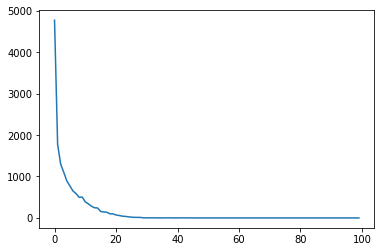

In [9]:
df_error1 = pd.DataFrame({'n_errores': np.linspace(0, 99, 100), 'n_tableros': n_errores_2t})
plt.figure()
plt.plot(df_error1['n_tableros'])
plt.show()

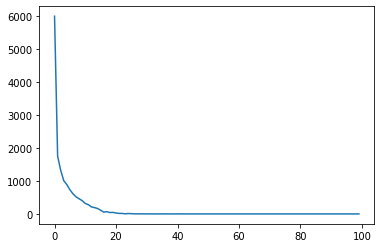

In [10]:
df_error2 = pd.DataFrame({'n_errores': np.linspace(0, 99, 100), 'n_tableros': n_errores_8t})
plt.figure()
plt.plot(df_error2['n_tableros'])
plt.show()

In [11]:
fig, ax = plt.subplots(3,1, figsize=(6, 12))
ax[0].plot(df_error['n_tableros'], label='# tableros')
ax[0].set_title("Usando las cabeceras sin modificar")
ax[0].set_xlabel('# errores')
ax[0].set_ylim((0,7000))
ax[1].plot(df_error1['n_tableros'], label='# tableros')
ax[1].set_title("Usando las 2 primeras reflexiones")
ax[1].set_xlabel('# errores')
ax[1].set_ylim((0,7000))
ax[2].plot(df_error2['n_tableros'], label='# tableros')
ax[2].set_title("Usando las 8 reflexiones")
ax[2].set_xlabel('# errores')
ax[2].set_ylim((0,7000))
fig.tight_layout()
plt.savefig('reflexiones.png', transparent=True)
plt.show()


In [12]:
df_error[df_error['n_tableros']>0].iloc[-1]

n_errores     51.0
n_tableros     1.0
Name: 51, dtype: float64

In [13]:
df_error1[df_error1['n_tableros']>0].iloc[-1]

n_errores     42.0
n_tableros     2.0
Name: 42, dtype: float64

In [14]:
df_error2[df_error2['n_tableros']>0].iloc[-1]

n_errores     41.0
n_tableros     1.0
Name: 41, dtype: float64

In [15]:
df_error.head()

n_errores  n_tableros
0        0.0      4163.0
1        1.0      1806.0
2        2.0      1293.0
3        3.0      1073.0
4        4.0       907.0

In [16]:
df_error1.head()

n_errores  n_tableros
0        0.0      4770.0
1        1.0      1774.0
2        2.0      1296.0
3        3.0      1100.0
4        4.0       892.0

In [17]:
df_error2.head()

n_errores  n_tableros
0        0.0      5998.0
1        1.0      1755.0
2        2.0      1323.0
3        3.0      1008.0
4        4.0       888.0

In [18]:
total_tableros = df_error['n_tableros'].sum()

In [19]:
print(f'{n_errores_1t[0]/total_tableros*100} {n_errores_2t[0]/total_tableros*100} {n_errores_8t[0]/total_tableros*100}')

27.25546680633757 31.22954039544324 39.26934660206888
